# Project \#3 - Face generation

### Deep Learning course -  A.Y. 2019-2020

Students:
- Simone Gayed Said
- Pierpasquale Colagrande


## Import of fundamental libraries
Here we import fundamental libraries as TensorFlow, Numpy etc.

In [0]:
%tensorflow_version 2.x

In [2]:
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape, Concatenate, Lambda, Layer
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import mean_squared_error, binary_crossentropy
from keras import backend as K
from keras import metrics
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from scipy.linalg import sqrtm
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
from zipfile import ZipFile
from google.colab import drive
drive.mount("/content/drive")

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## Input pipeline

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 2025 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.


In [0]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000
ORIGINAL_IMAGE_SIZE = (218, 178, 3)
TARGET_IMAGE_SIZE = (64, 64, 3)
ATTRIBUTES_SIZE = 40
LATENT_DIM = 64
EPOCHS = 10
NUM_IMAGES=202599

DATA_DRIVE_FOLDER = 'drive/My Drive/Face Generation/'
CELEBA_FILE = "img_align_celeba.zip"
CELEBA_IMAGE_FOLDER = "img_align_celeba/"
ATTRIBUTE_FILE = "list_attr_celeba.txt"

In [0]:
def celeba_generator():
  attributes = np.array(pd.read_csv(DATA_DRIVE_FOLDER + ATTRIBUTE_FILE, skiprows=2, header=None, delim_whitespace=True))
  with ZipFile(DATA_DRIVE_FOLDER + CELEBA_FILE, 'r') as img_dataset_file:
    while True:
      images = attributes[np.random.choice(attributes.shape[0], BATCH_SIZE, replace=False)]
      image_batch = []
      attributes_batch = []
      for image_info in images:
        image = cv2.imdecode(np.frombuffer(img_dataset_file.read(CELEBA_IMAGE_FOLDER + image_info[0]), np.uint8), cv2.IMREAD_COLOR)[...,::-1] / 255.0
        image = image[45:173 , 25:153]
        image = cv2.resize(src=image, dsize=(TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1]))
        image_batch += [image]
        attributes_batch += [image_info[1:]]
      image_batch = np.array(image_batch, dtype=np.float32)
      attribute_batch = np.array(attributes_batch, dtype=np.int32)

      yield [image_batch, attribute_batch], None

training_dataset = celeba_generator()

In [0]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.axis('off')

## Network model
Here, we build the network model.

In [6]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def create_encoding_block(x):
  x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu', name = 'encoder_conv_0')(x)
  x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu', name = 'encoder_conv_1')(x)
  x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu', name = 'encoder_conv_2')(x)
  x = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu', name = 'encoder_conv_3')(x)
  return x

def create_decoding_block(x):
  x = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu', name = 'decoder_conv_0')(x)
  x = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu', name = 'decoder_conv_1')(x)
  x = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu', name = 'decoder_conv_2')(x)
  x = Conv2DTranspose(filters = 3, kernel_size = 3, strides = 2,  padding = 'same', activation = 'sigmoid', name = 'decoder_conv_3')(x)
  return x

def create_vae():
  # Define encoder model.
  input_img = Input(shape = TARGET_IMAGE_SIZE, name='input_img')
  labels = Input(shape = (ATTRIBUTES_SIZE,), name='labels')

  enc_1 = create_encoding_block(input_img)

  shape_before_flattening = K.int_shape(enc_1)[1:]

  x = Flatten()(enc_1)

  z_mean = Dense(LATENT_DIM, name='z_mean')(x)
  z_log_sigma = Dense(LATENT_DIM, name='z_log_sigma')(x)
  z = Sampling()([z_mean, z_log_sigma])

  zy = Concatenate()([z, labels])

  inputs_embedding = Input(shape=(LATENT_DIM + ATTRIBUTES_SIZE,))
  embedding = Dense(np.prod(shape_before_flattening))(inputs_embedding)
  embedding = Reshape(shape_before_flattening)(embedding)

  x_hat = create_decoding_block(embedding)

  encoder = Model(inputs = [input_img, labels], outputs = zy, name="encoder")
  decoder = Model(inputs = inputs_embedding, outputs = x_hat, name="decoder")

  vae_out = decoder(encoder([input_img, labels]))

  rec_loss =  np.prod(TARGET_IMAGE_SIZE) * binary_crossentropy(Flatten()(input_img), Flatten()(vae_out))
  kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
  vae_loss = K.mean(rec_loss + kl_loss)

  vae = Model(inputs = [input_img, labels], outputs = vae_out, name="vae")

  vae.add_loss(vae_loss)

  optimizer = Adam(learning_rate=0.0005)
  vae.compile(optimizer)

  return vae, encoder, decoder

vae, encoder, decoder = create_vae()

vae.summary()
encoder.summary()
decoder.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
labels (InputLayer)             (None, 40)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 104)          912832      input_img[0][0]                  
                                                                 labels[0][0]                     
__________________________________________________________________________________________________
decoder (Model)                 (None, 64, 64, 3)    818243      encoder[1][0]                  

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [7]:
vae.fit(training_dataset, steps_per_epoch=NUM_IMAGES//BATCH_SIZE, verbose=1, epochs=EPOCHS)

# Save model weights
vae.save_weights(DATA_DRIVE_FOLDER + 'vae.h5')
decoder.save_weights(DATA_DRIVE_FOLDER + 'decoder.h5')
encoder.save_weights(DATA_DRIVE_FOLDER + 'encoder.h5')

Epoch 1/10


KeyboardInterrupt: ignored

In [0]:
vae.load_weights(DATA_DRIVE_FOLDER + 'vae.h5')
decoder.load_weights(DATA_DRIVE_FOLDER + 'decoder.h5')
encoder.load_weights(DATA_DRIVE_FOLDER + 'encoder.h5')

In [0]:
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, order=1)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)

def calculate_fid(act1 , act2):
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  ssdiff = np.sum((mu1 - mu2)**2.0)
  covmean = sqrtm(sigma1.dot(sigma2))
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

inception_model = InceptionV3(include_top=False, pooling='avg')

In [0]:
def celeba_vae_eval_generator():
  attributes = np.array(pd.read_csv(DATA_DRIVE_FOLDER + ATTRIBUTE_FILE, skiprows=2, header=None, delim_whitespace=True))
  attributes = attributes[np.random.choice(attributes.shape[0], 10000, replace=False)]
  with ZipFile(DATA_DRIVE_FOLDER + CELEBA_FILE, 'r') as img_dataset_file:
    batched = 0
    while batched < 10000:
      images = attributes[batched: batched + BATCH_SIZE]
      image_batch = []
      attributes_batch = []
      for image_info in images:
        image = cv2.imdecode(np.frombuffer(img_dataset_file.read(CELEBA_IMAGE_FOLDER + image_info[0]), np.uint8), cv2.IMREAD_COLOR)[...,::-1] / 255.0
        image = image [45:173 , 25:153]
        image = cv2.resize(src=image, dsize=(TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1]))
        image_batch += [image]
        attributes_batch += [image_info[1:]]
      image_batch = np.array(image_batch, dtype=np.float32)
      attribute_batch = np.array(attributes_batch, dtype=np.int32)

      batched += BATCH_SIZE

      yield [image_batch, attribute_batch]

validation_dataset = celeba_vae_eval_generator()

Calculating activations for each batch...
Batch 1 - Num. samples: 128
Batch 2 - Num. samples: 128
Batch 3 - Num. samples: 128
Batch 4 - Num. samples: 128
Batch 5 - Num. samples: 128
Batch 6 - Num. samples: 128
Batch 7 - Num. samples: 128
Batch 8 - Num. samples: 128
Batch 9 - Num. samples: 128
Batch 10 - Num. samples: 128
Batch 11 - Num. samples: 128
Batch 12 - Num. samples: 128
Batch 13 - Num. samples: 128
Batch 14 - Num. samples: 128
Batch 15 - Num. samples: 128
Batch 16 - Num. samples: 128
Batch 17 - Num. samples: 128
Batch 18 - Num. samples: 128
Batch 19 - Num. samples: 128
Batch 20 - Num. samples: 128
Batch 21 - Num. samples: 128
Batch 22 - Num. samples: 128
Batch 23 - Num. samples: 128
Batch 24 - Num. samples: 128
Batch 25 - Num. samples: 128
Batch 26 - Num. samples: 128
Batch 27 - Num. samples: 128
Batch 28 - Num. samples: 128
Batch 29 - Num. samples: 128
Batch 30 - Num. samples: 128
Batch 31 - Num. samples: 128
Batch 32 - Num. samples: 128
Batch 33 - Num. samples: 128
Batch 34 -

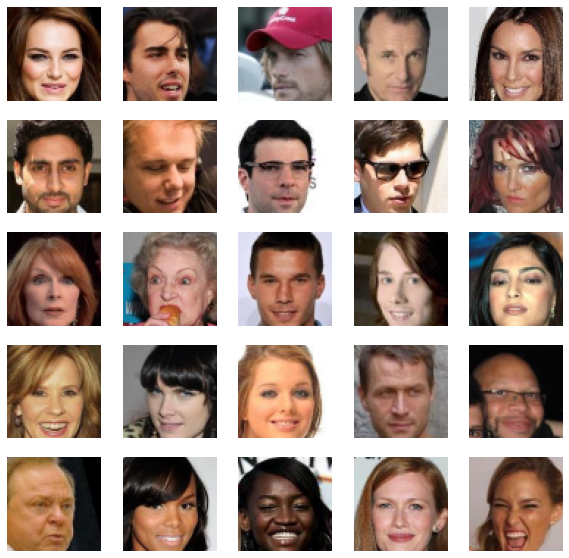

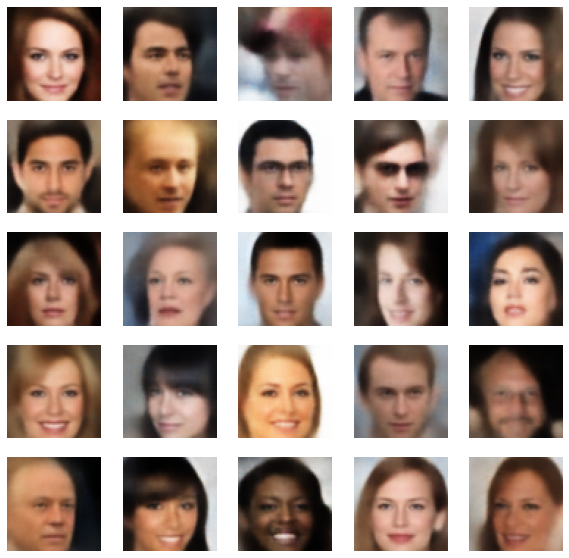

In [11]:
print("Calculating activations for each batch...")
img_act = np.array([]).reshape((0, 2048))
pred_act = np.array([]).reshape((0, 2048))
i = 1
for batch in validation_dataset:
  images = batch[0]
  print("Batch", i, "- Num. samples:", images.shape[0])
  predictions = vae.predict(batch)
  if i == 1:
    imgs1 = images
    prediction1 = predictions
  images = images * 255.0
  predictions = predictions * 255.0
  images1 = scale_images(images, (299, 299, 3))
  images1 = preprocess_input(images1)
  images2 = scale_images(predictions, (299, 299, 3))
  images2 = preprocess_input(images2)
  a = inception_model.predict(images1)
  b = inception_model.predict(images2)
  img_act = np.concatenate((img_act, a), axis = 0)
  pred_act = np.concatenate((pred_act, b), axis = 0)
  i += 1
print("Done!")
show_batch(imgs1)
show_batch(prediction1)


In [12]:
print("Calculating score for reconstruction...")
fid_score = calculate_fid(img_act, pred_act)
print("Done!")
print("Score for reconstruction:")
print(fid_score)

Calculating score for reconstruction...
Done!
Score for reconstruction:
64.42203627159486


Calculating activations for each batch...
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
Batch 1 - Num. samples: 128
Batch 2 - Num. samples: 128
Batch 3 - Num. samples: 128
Batch 4 - Num. samples: 128
Batch 5 - Num. samples: 128
Batch 6 - Num. samples: 128
Batch 7 - Num. samples: 128
Batch 8 - Num. samples: 128
Batch 9 - Num. samples: 128
Batch 10 - Num. samples: 128
Batch 11 - Num. samples: 128
Batch 12 - Num. samples: 128
Batch 13 - Num. samples: 128
Batch 14 - Num. samples: 128
Batch 15 - Num. samples: 128
Batch 16 - Num. samples: 128
Batch 17 - Num. samples: 128
Batch 18 - Num. samples: 128
Batch 19 - Num. samples: 128
Batch 20 - Num. samples: 128
Batch 21 - Num. samples: 128
Batch 22 - Num. samples: 128
Batch 23 - Num. samples: 128
Batch 24 - Num. samples: 128
Batch 25 - Num. samples: 128
Batch 26 - Num. samples: 128
Batch 27 - Num. samples: 128
Batch 28 - Num. samples: 128

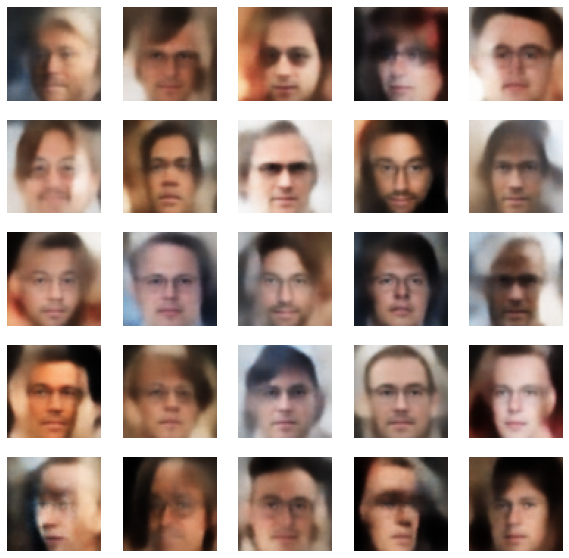

In [15]:
print("Calculating activations for each batch...")
z_sample = np.random.randn(10000, LATENT_DIM).astype(np.float32)

"""
attributes = np.array(pd.read_csv(DATA_DRIVE_FOLDER + ATTRIBUTE_FILE, skiprows=2, header=None, delim_whitespace=True))
attributes = attributes[np.random.choice(attributes.shape[0], 10000, replace=False)][:, 1:]
label = attributes.astype(np.int32)
"""

label = np.full(shape=(10000,ATTRIBUTES_SIZE), fill_value=-1, dtype=np.int32)
label[:, 20] = 1
label[:, 15] = 1

z = np.concatenate((z_sample, label), axis=1)

batched = 0
count = 0
pred_act = np.array([]).reshape((0, 2048))
while batched < 10000:
  count += 1
  z_batch = z[batched: batched + BATCH_SIZE]
  print("Batch", count, "- Num. samples:", z_batch.shape[0])
  predictions = decoder.predict(z_batch)
  if count == 1:
    prediction1 = predictions
  predictions = predictions * 255.0
  images2 = scale_images(predictions, (299, 299, 3))
  images2 = preprocess_input(images2)
  a = inception_model.predict(images2)
  pred_act = np.concatenate((pred_act, a), axis = 0)
  batched += BATCH_SIZE

show_batch(prediction1)

In [16]:
print("Calculating score for generation...")
fid_score = calculate_fid(img_act, pred_act)
print("Score for generation:")
print(fid_score)

Calculating score for generation...
Score for generation:
86.47228749499308
